# Problem description

We are provided with the data of 145k wikipedia pages and daily view count for each of them for 550 days starting from July, 1st, 2015 up until December 31st, 2016. Data is from an ads and marketing based company helping businesses evoke maximum clicks at minimum cost. Analyse the data and perform forecasting on the number of views so that we can predict and optimize the ad placement for clients. Clients belong to different regions and need data on how their ads will perform on pages in different languages.

Concepts Used: Time Series forecasting- ARIMA, SARIMAX, and Prophet

In [ ]:
import pandas as pd
import numpy as np
import pylab as p
import matplotlib.pyplot as plot
from collections import Counter
import re
import os
import seaborn as sns

In [ ]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

In [ ]:
train = pd.read_csv('/content/train_1.csv')

In [ ]:
train.head()

In [ ]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB
None


In [ ]:
train.isnull().sum()

Page              0
2015-07-01    20740
2015-07-02    20816
2015-07-03    20544
2015-07-04    20654
              ...  
2016-12-27     3701
2016-12-28     3822
2016-12-29     3826
2016-12-30     3635
2016-12-31     3465
Length: 551, dtype: int64

There are some null values in the data.

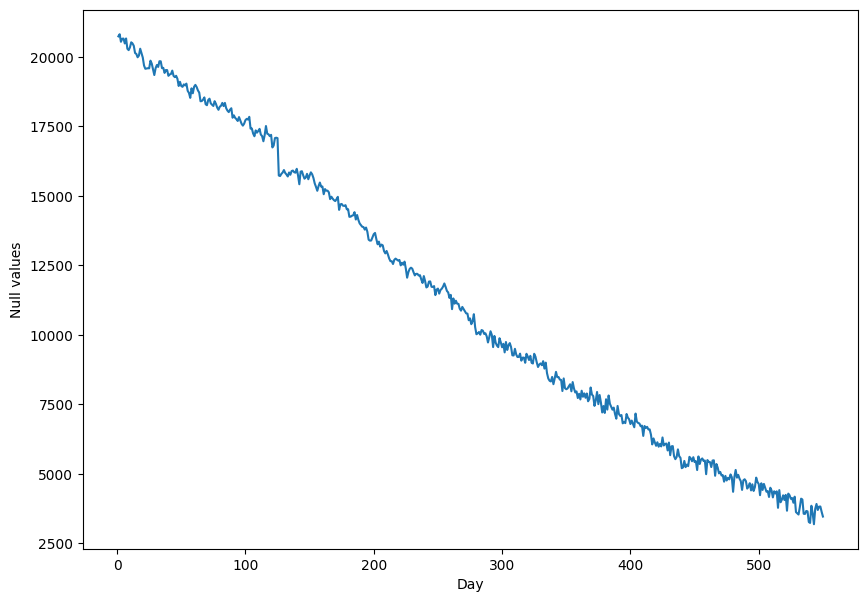

In [ ]:
days = [r for r in range(1, len(train.columns))]
plot.figure(figsize=(10,7))
plot.xlabel('Day')
plot.ylabel('Null values')
plot.plot(days, train.isnull().sum()[1:])

Number of null values decrease with time.

Probable reason: Some website have all nan values in the begining, may be due to the fact that those websites were created post that date and so no traffic.

In [ ]:
print(train.shape)
train=train.dropna(how='all')
print(train.shape)
train=train.dropna(thresh=300)
train.reset_index(inplace=True,drop=True)
print(train.shape)
train.head(10)

In [ ]:
train=train.fillna(0)
train.tail()

1. Rows with null values in all columns are dropped.

2. Dropped rows with more than 300 Nulls, because the time series for that would not make much sense

3. We fill all the remaining values with zero assuming there was no traffic on the date.


# ***EDA***

In [ ]:
train['Page'][0]

'2NE1_zh.wikipedia.org_all-access_spider'

 The page values are in this format


 **SPECIFIC NAME _ LANGUAGE.wikipedia.org _ ACCESS TYPE _ ACCESS ORIGIN**

having information about page name, the main domain, device type used to access the page, and also the request origin(spider or browser agent)


In [ ]:
def split_page(page):
    w = re.split('_|\.', page)
    return w[:-5],w[-5],w[-2],w[-1]

li = list(train['Page'].apply(lambda x: split_page(str(x))))
df1 = pd.DataFrame(li)
df1.columns = ['Title', 'Language', 'Access_type','Access_origin']
df = pd.concat([train, df1], axis = 1)
df.head(5)

<Axes: xlabel='Language', ylabel='count'>

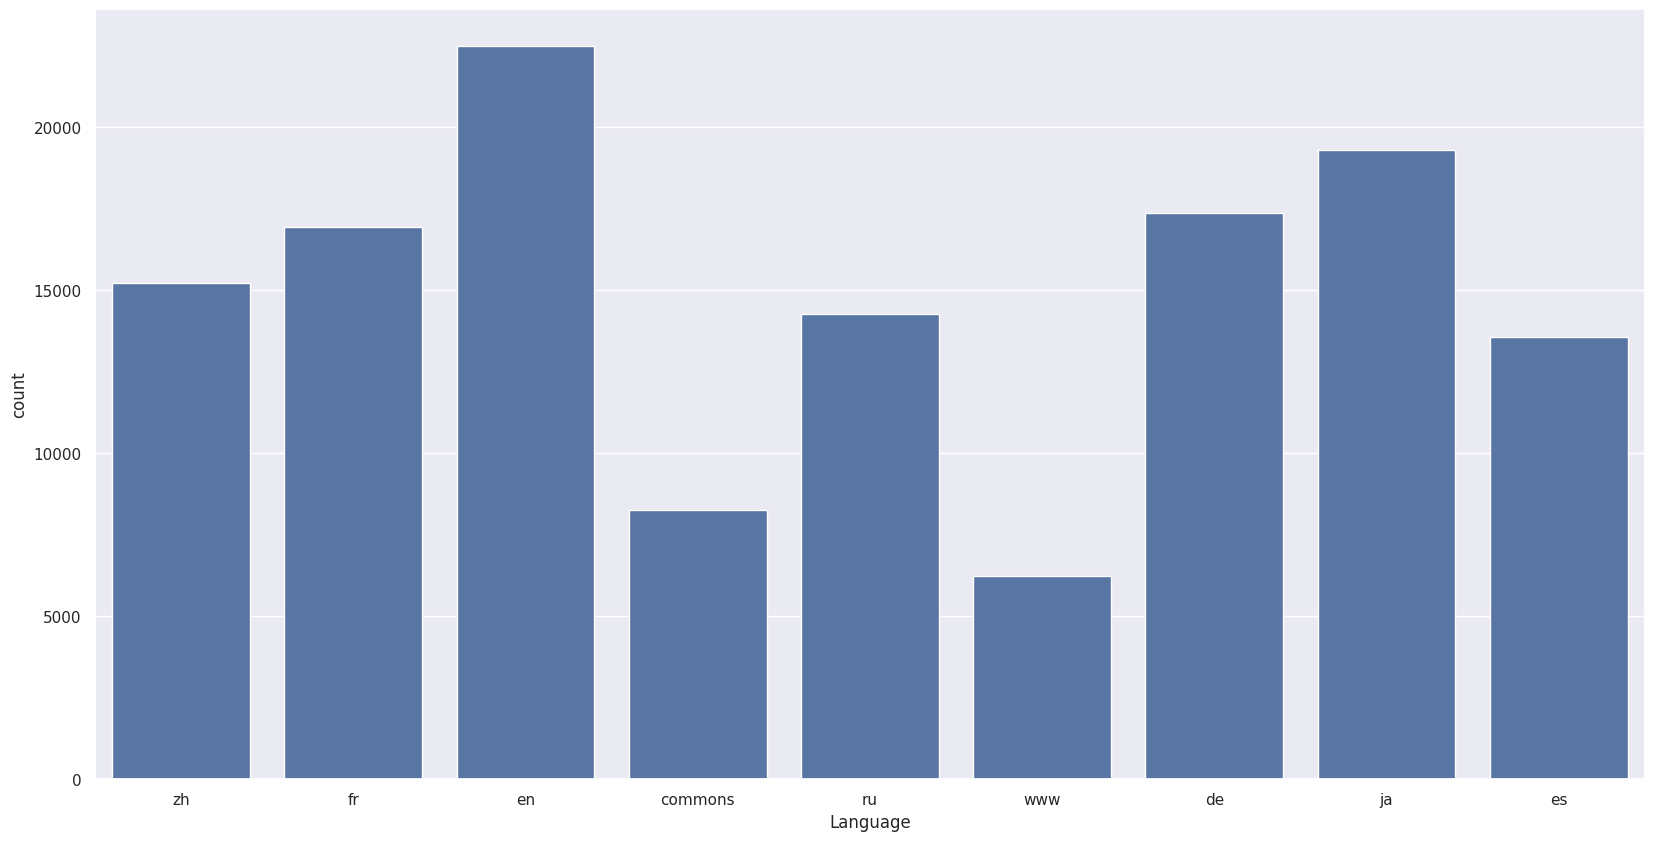

In [ ]:
sns.set(rc={'figure.figsize':(20,10)})
sns.countplot(x=df['Language'])

<Axes: xlabel='Access_type', ylabel='count'>

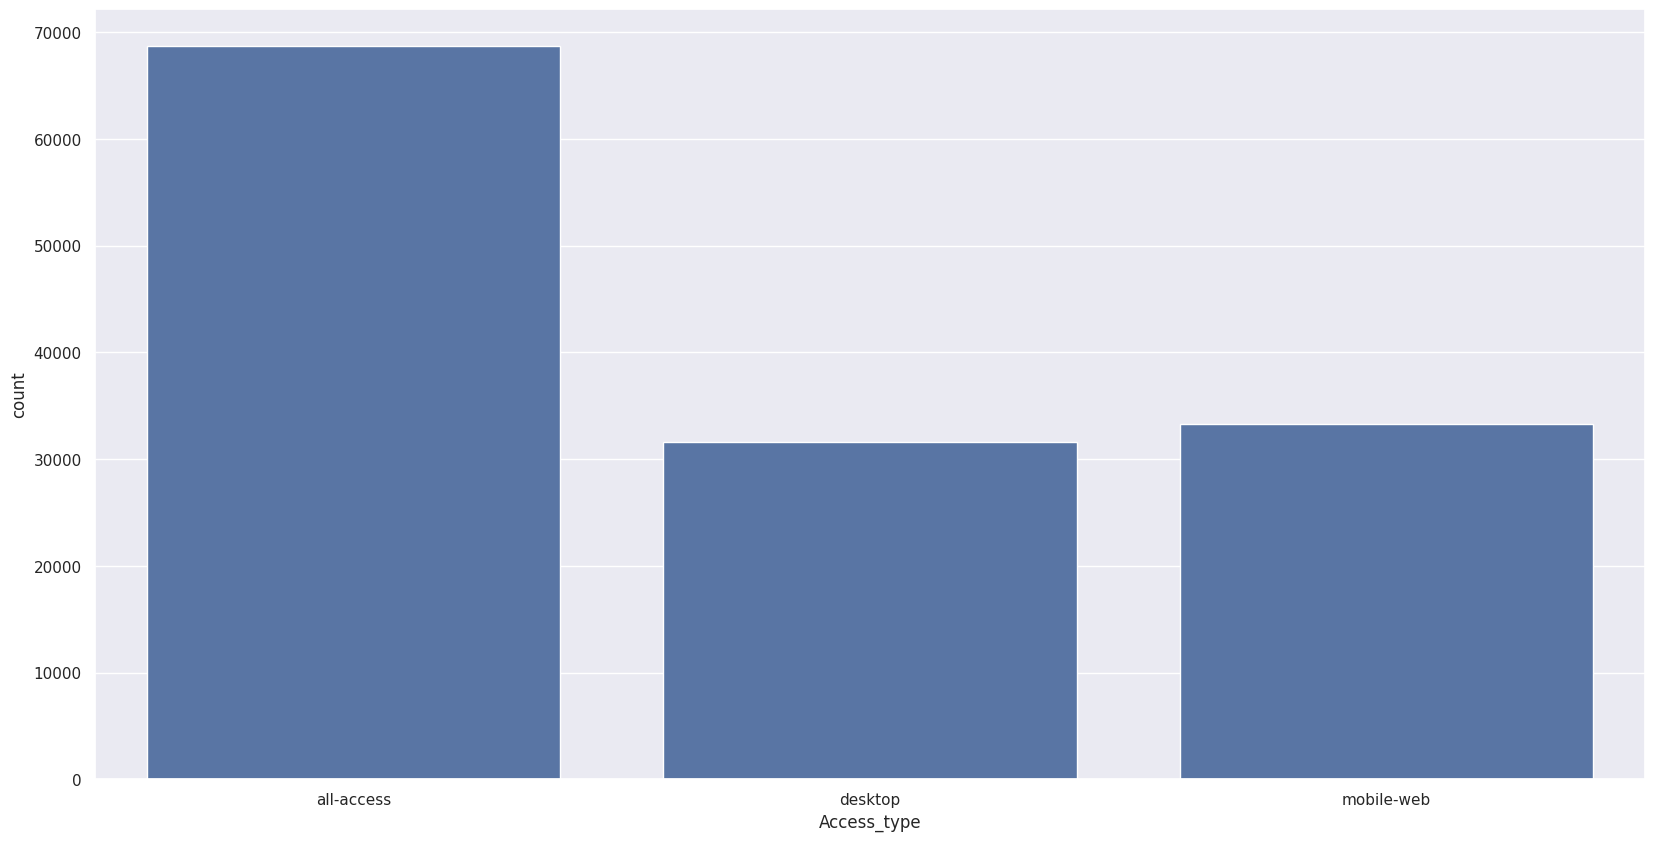

In [ ]:
sns.countplot(x=df['Access_type'])

Views from desktop and mobile are almost the same

<Axes: xlabel='Access_origin', ylabel='count'>

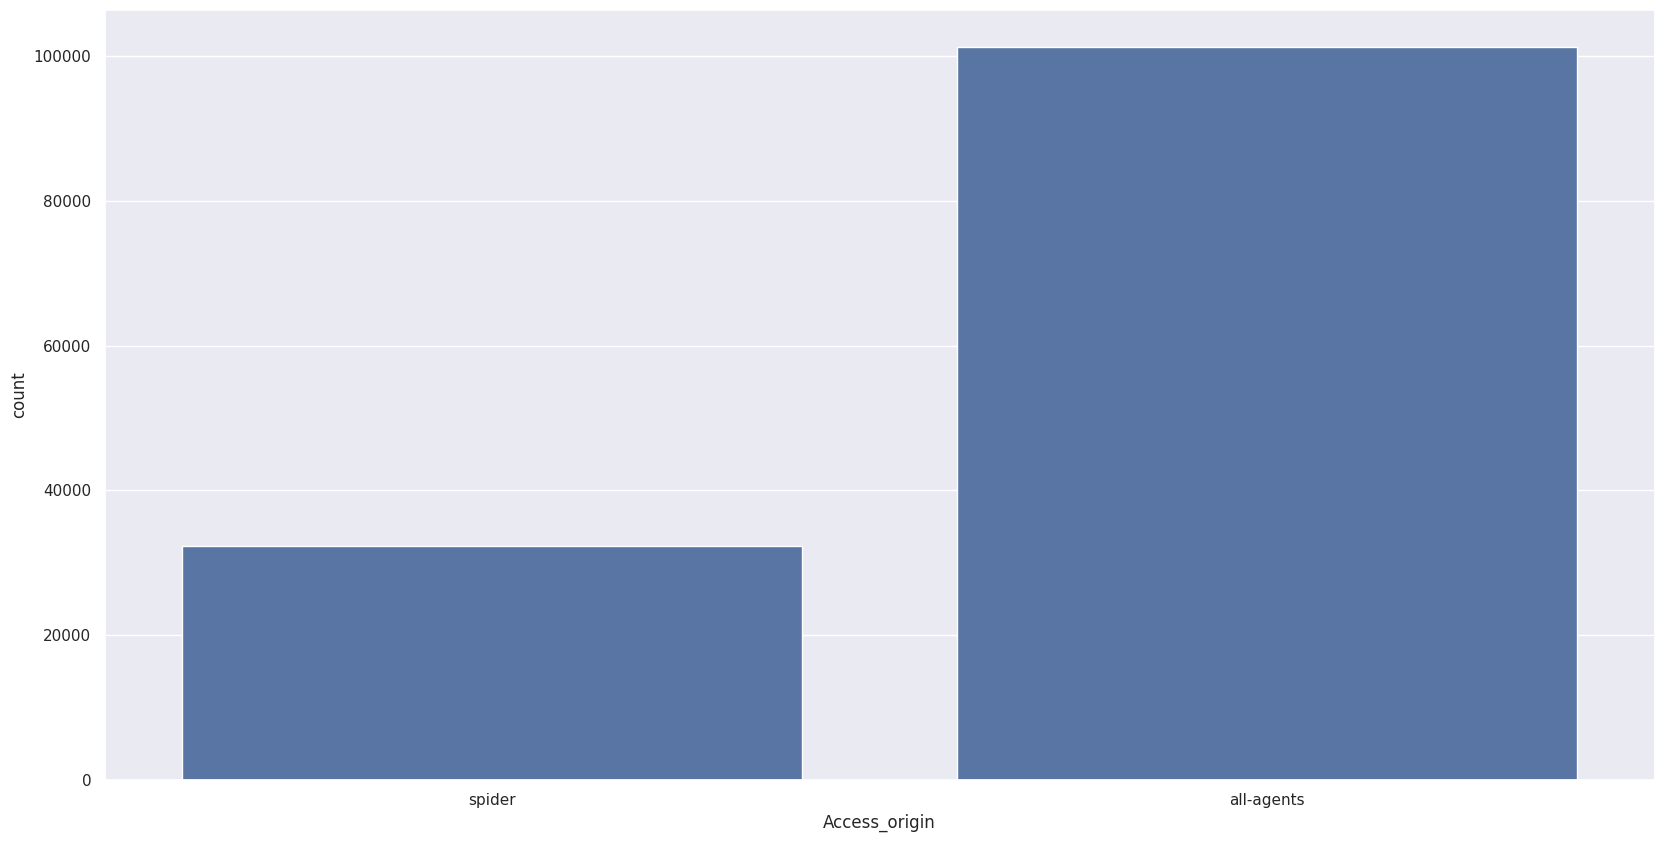

In [ ]:
sns.countplot(x=df['Access_origin'])

This shows that organic view is far more than that of spiders or bots

We need to make some cleaning in Language column. There are 'Common','WWW' in language categories which need to be fixed.

In [ ]:
df.loc[(df['Language']=='commons') | (df['Language']=='www'),'Language']="no_lang"
df[(df['Language']=='commons') | (df['Language']=='www')]['Language']
df['Language'].unique()

array(['zh', 'fr', 'en', 'no_lang', 'ru', 'de', 'ja', 'es'], dtype=object)

In [ ]:
df_language=df.groupby('Language').mean(numeric_only=True).transpose()
df_language.head(10)

Language,de,en,es,fr,ja,no_lang,ru,zh
2015-07-01,763.765926,3767.328604,1127.485204,499.092872,614.637160,102.733545,663.199229,272.498521
2015-07-02,753.362861,3755.158765,1077.485425,502.297852,705.813216,107.663447,674.677015,272.906778
2015-07-03,723.074415,3565.225696,990.895949,483.007553,637.451671,101.769629,625.329783,271.097167
2015-07-04,663.537323,3711.782932,930.303151,516.275785,800.897435,86.853871,588.171829,273.712379
2015-07-05,771.358657,3833.433025,1011.759575,506.871666,768.352319,96.254105,626.385354,291.977713
2015-07-06,849.080636,4127.429067,1153.091801,528.072752,669.544493,110.188147,674.764681,293.490632
2015-07-07,823.422532,3906.341724,1123.942440,510.426481,651.298938,116.865600,659.297617,293.170337
2015-07-08,835.455305,3685.854621,1090.832190,501.033632,647.372428,121.979785,656.209530,300.824206
2015-07-09,804.329513,3771.183714,1070.245812,495.848124,631.090645,106.408928,672.200981,298.983433
2015-07-10,749.593653,3749.860313,972.952328,467.943179,655.678362,107.514834,769.787596,310.819736


In [ ]:
df_language.reset_index(inplace=True)
df_language.set_index('index', inplace=True)
df_language.head()

Language,de,en,es,fr,ja,no_lang,ru,zh
index,,,,,,,,
2015-07-01,763.765926,3767.328604,1127.485204,499.092872,614.637160,102.733545,663.199229,272.498521
2015-07-02,753.362861,3755.158765,1077.485425,502.297852,705.813216,107.663447,674.677015,272.906778
2015-07-03,723.074415,3565.225696,990.895949,483.007553,637.451671,101.769629,625.329783,271.097167
2015-07-04,663.537323,3711.782932,930.303151,516.275785,800.897435,86.853871,588.171829,273.712379
2015-07-05,771.358657,3833.433025,1011.759575,506.871666,768.352319,96.254105,626.385354,291.977713


Text(0, 0.5, 'Views per Page')

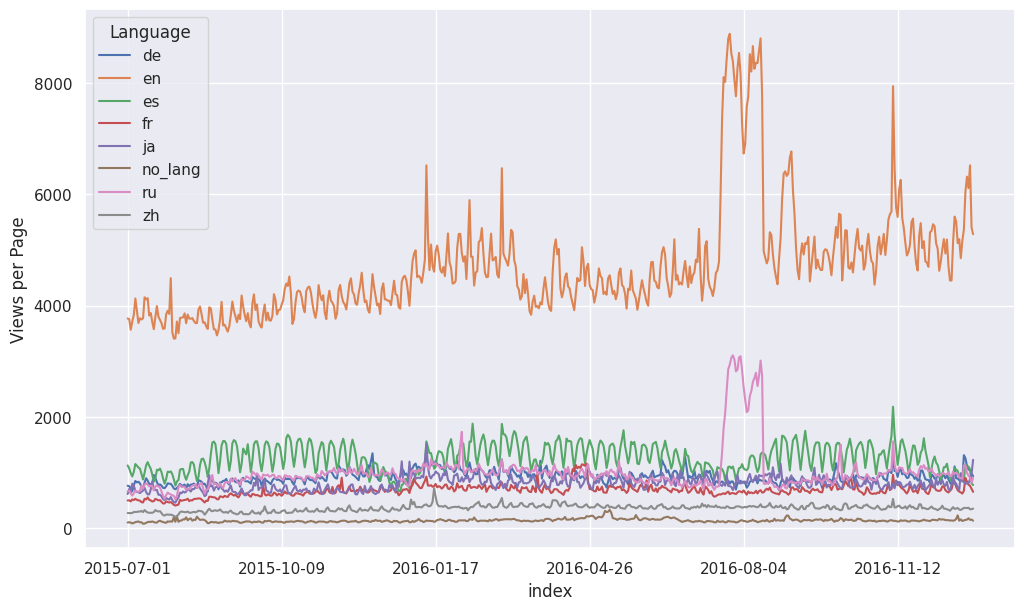

In [ ]:
df_language.plot(figsize=(12,7))
plot.ylabel('Views per Page')

Articles in english get the most number of views as compared to different languages, there are some spikes at different times in different laguages.

Text(0, 0.5, 'Views per Page')

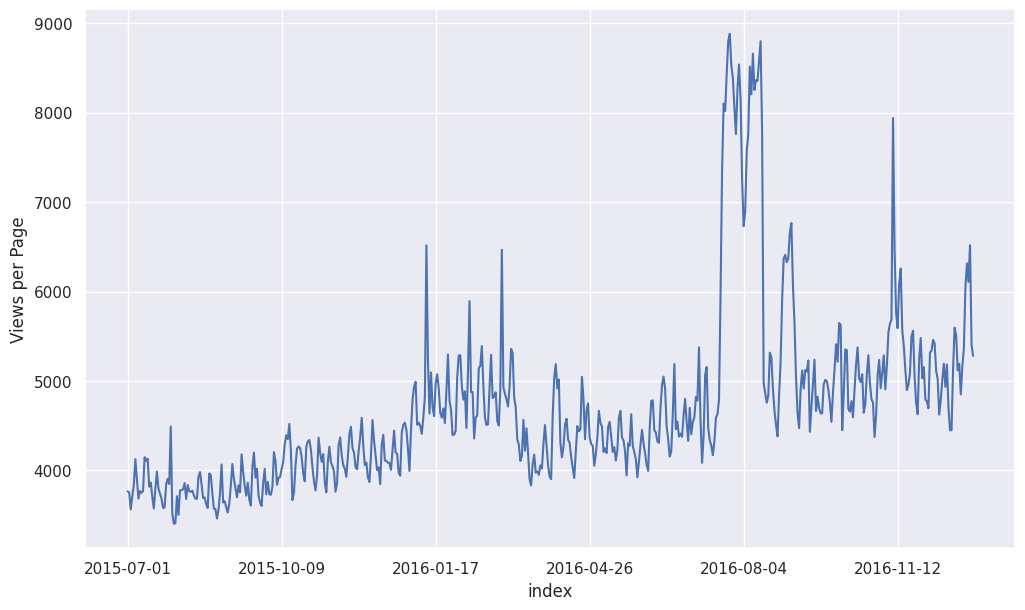

In [ ]:
df_language['en'].plot(figsize=(12,7))
plot.ylabel('Views per Page')

In [ ]:
total_view=df_language.copy()

# Checking the stationarity

**Dickey-Fuller test**

Null Hypothesis (H0): Series is non-stationary

Alternate Hypothesis (HA): Series is stationary

p-value >0.05 Fail to reject (H0)

p-value <= 0.05 Accept (H1)


In [ ]:
from statsmodels.tsa.stattools import adfuller
def df_test(x):
    result=adfuller(x)
    print('ADF Stastistic: %f'%result[0])
    print('p-value: %f'%result[1])

df_test(total_view['en'])

ADF Stastistic: -2.373563
p-value: 0.149337


p-value>0.05 . We fail to reject the null hypothesis and so time series is non stationary.

# Making the time series stationary


In [ ]:
ts=total_view['en']

## 1. Remove trend and seasonality with decomposition

There are three components to a time series:

  -> trend how things are overall changing

  -> seasonality how things change within a given period e.g. a year, month, week, day
  
  -> error/residual/irregular activity not explained by the trend or the seasonal value

How these three components interact determines the difference between a multiplicative and an additive time series.

In a multiplicative time series, the components multiply together to make the time series. If you have an increasing trend, the amplitude of seasonal activity increases. Everything becomes more exaggerated. This is common when you’re looking at web traffic.

In an additive time series, the components add together to make the time series. If you have an increasing trend, you still see roughly the same size peaks and troughs throughout the time series. This is often seen in indexed time series where the absolute value is growing but changes stay relative.


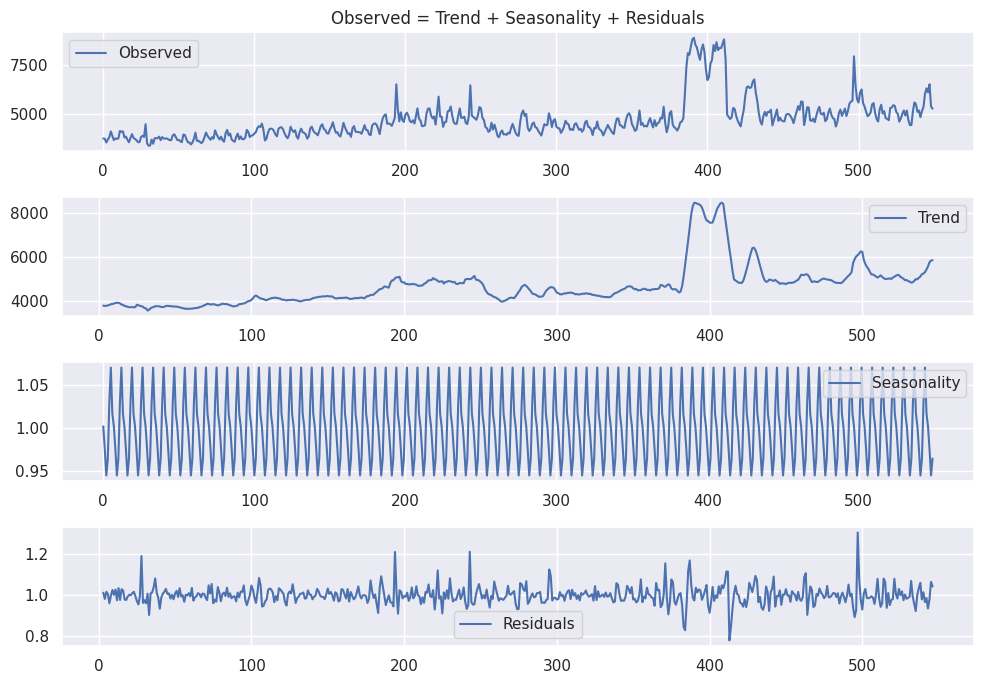

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts.values, model='multiplicative',period=7)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plot.figure(figsize=(10,7))
plot.subplot(411)
plot.title('Observed = Trend + Seasonality + Residuals')
plot.plot(ts.values,label='Observed')
plot.legend(loc='best')
plot.subplot(412)
plot.plot(trend, label='Trend')
plot.legend(loc='best')
plot.subplot(413)
plot.plot(seasonal,label='Seasonality')
plot.legend(loc='best')
plot.subplot(414)
plot.plot(residual, label='Residuals')
plot.legend(loc='best')
plot.tight_layout()
plot.show()

In [ ]:
ts_decompose=pd.DataFrame(residual).fillna(0)[0].values
df_test(ts_decompose)

ADF Stastistic: -3.796320
p-value: 0.002945


p-value < 0.05. That means we can accept alternate hypothesis and so time series is now stationary. We can also try differencing to remove trend and seasonality.

# 2. Remove trend and seasonality with differencing


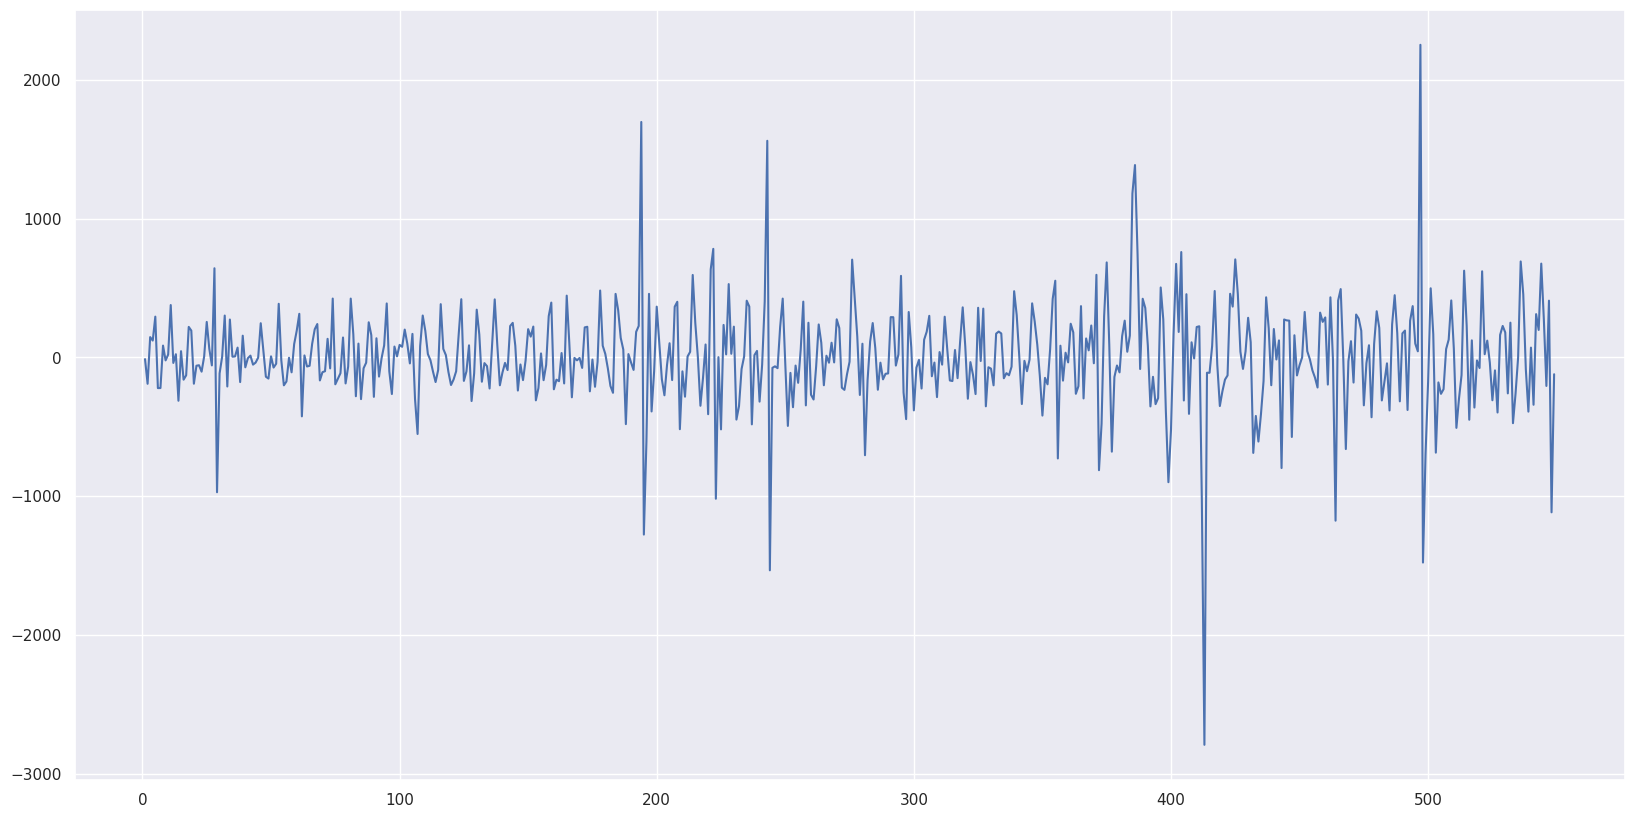

In [ ]:
ts_diff = ts - ts.shift(1)
plot.plot(ts_diff.values)
plot.show()

In [ ]:
ts_diff.dropna(inplace=True)
df_test(ts_diff)

ADF Stastistic: -8.273590
p-value: 0.000000


 p-value is 0. Timeseries is now stationary.

# Plot the autocorrelation and partial auto correlation functions

Plotting the graphs and getting the p,q,d values for ARIMA

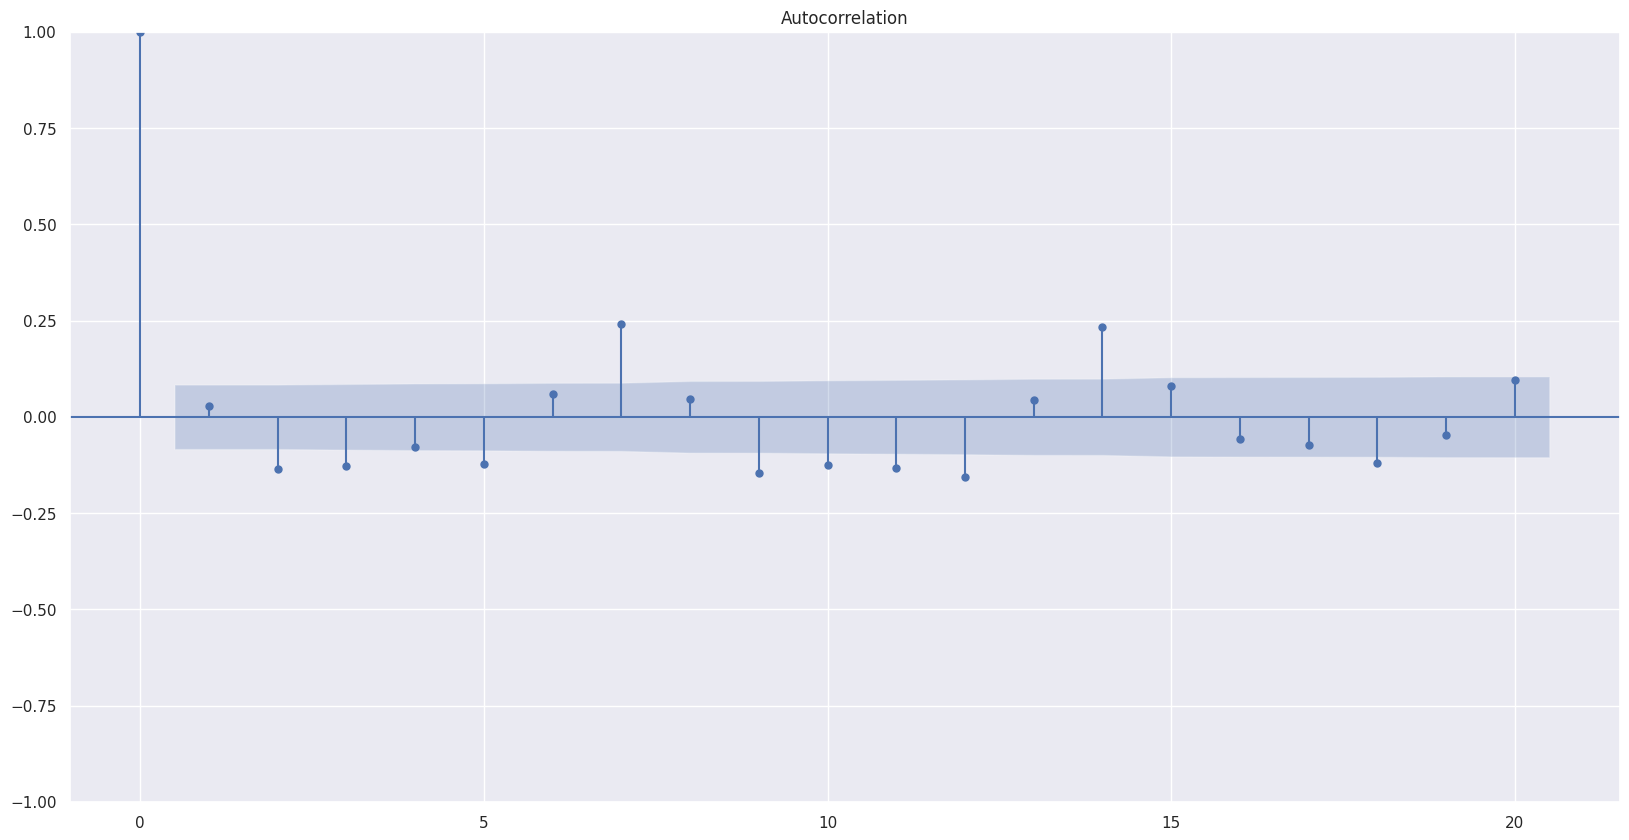

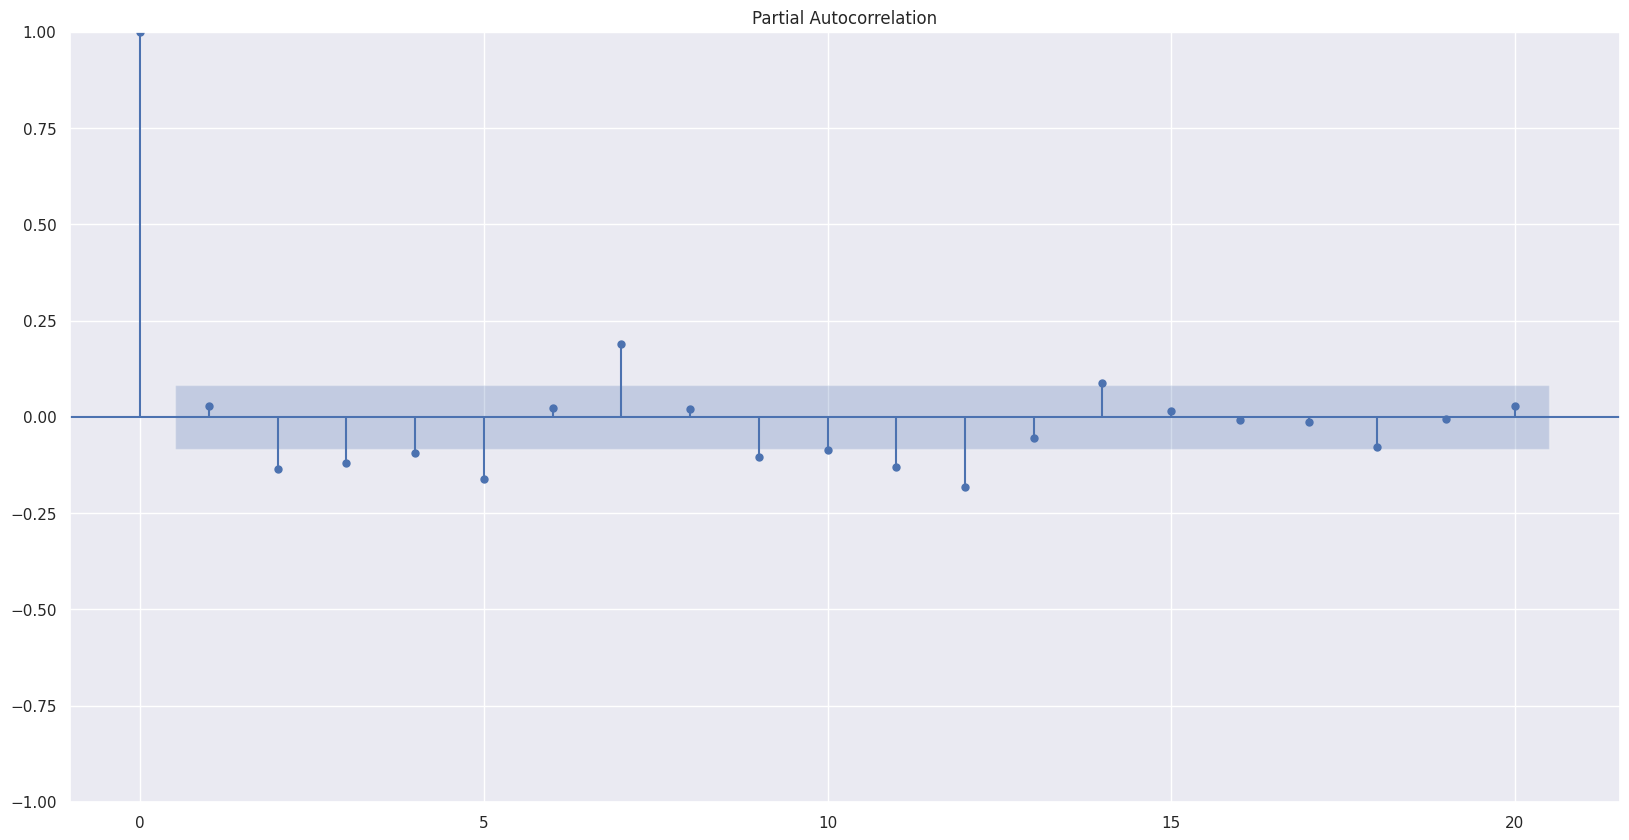

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
acf=plot_acf(ts_diff,lags=20)
pacf=plot_pacf(ts_diff,lags=20)

# ARIMA MODEL

**Choosing p,d,q for ARIMA model**

p: The lag order, representing the number of lag observations incorporated in
the model.

d: Degree of differencing, denoting the number of times raw observations undergo differencing.

q: Order of moving average, indicating the size of the moving average window

We use PACF for p, here we see that till lag 5 there are significat lines, if
we want our model to be simpler we can start with a smaller number like 3 or 4

We use ACF for q. here we can see that lag 4 is below significant level so we will use till lag 3

We can see that at 1 diffencing the series becomes stationary so we choose d as 1

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame

In [ ]:
model = ARIMA(ts, order=(4,1,3))
model_fit = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
model_fit.predict(dynamic=False)
plot.show()

**Multistep forecasting**

In [ ]:
train = ts[:-20]
test = ts[-20:]

In [ ]:
model = ARIMA(train, order=(4, 1, 3))
fitted = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
fitted.forecast(20, alpha=0.02)

2016-12-12    5126.193110
2016-12-13    5065.124186
2016-12-14    4873.143209
2016-12-15    4696.258484
2016-12-16    4666.380535
2016-12-17    4807.272349
2016-12-18    5011.582140
2016-12-19    5126.712471
2016-12-20    5064.726392
2016-12-21    4873.537697
2016-12-22    4695.885021
2016-12-23    4666.764946
2016-12-24    4806.888523
2016-12-25    5011.948703
2016-12-26    5126.330730
2016-12-27    5065.099581
2016-12-28    4873.175870
2016-12-29    4696.262758
2016-12-30    4666.402459
2016-12-31    4807.247382
Freq: D, Name: predicted_mean, dtype: float64

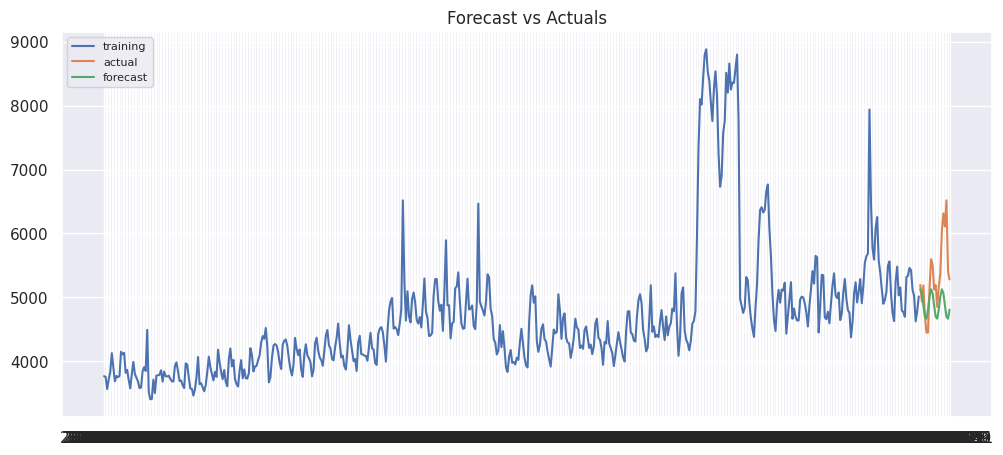

In [ ]:
# Forecast
fc = fitted.forecast(20, alpha=0.02)

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
# Plot
plot.figure(figsize=(12,5), dpi=100)
plot.plot(train, label='training')
plot.plot(test, label='actual')
plot.plot(fc_series, label='forecast')

plot.title('Forecast vs Actuals')
plot.legend(loc='upper left', fontsize=8)

In [ ]:
mape = np.mean(np.abs(fc - test.values)/np.abs(test.values))
rmse = np.mean((fc - test.values)**2)**.5
print("mape:",mape)
print("rsme:",rmse)

mape: 0.08968868098614681
rsme: 682.637296334911


Model does not perform very well for multistep out sample data.

From the decomposition we can see that there is a weekly seasonality and still some spikes in the residual, that may be because of some external factors, which we can take into account by using them as our exogenous variable

In [ ]:
ex_df = pd.read_csv('Exog')
ex_df.head()

,Exog
0,0
1,0
2,0
3,0
4,0


In [ ]:
exog=ex_df['Exog'].to_numpy()


We will train a sarimax model for that and see if we get any improvements from using the two information.The seasonal order and the values of PDQ are based upon various trials and comparision of the models
- We see a seasonality of 7 from the plots ie: weekly seasonality ( from the plots we can see that afte some insignificant plots we have some significant values repeating at intervals of 7 ie: 7,14 ... )


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


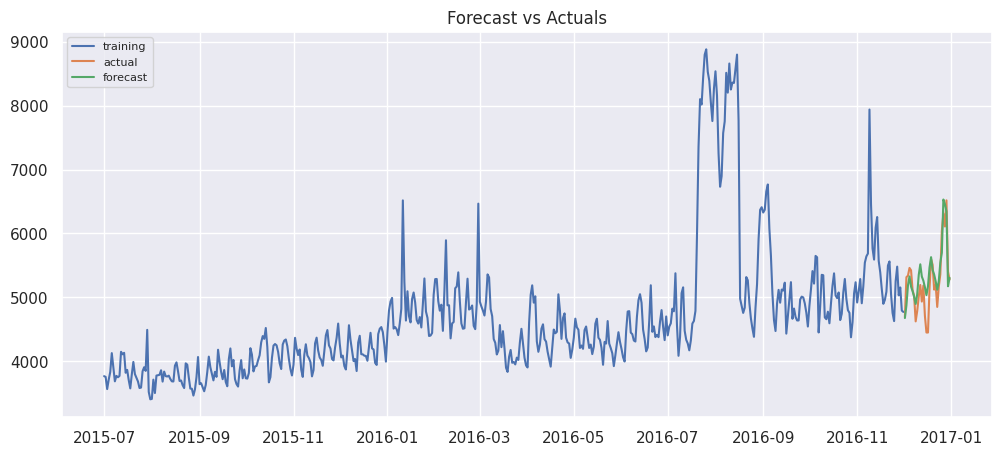

In [ ]:
import statsmodels.api as sm
train=ts[:520]
test=ts[520:]
model=sm.tsa.statespace.SARIMAX(train,order=(4, 1, 3),seasonal_order=(1,1,1,7),exog=exog[:520])
results=model.fit()

fc=results.forecast(30,dynamic=True,exog=pd.DataFrame(exog[520:]))

# Make as pandas series
fc_series = pd.Series(fc)
# Plot
train.index=train.index.astype('datetime64[ns]')
test.index=test.index.astype('datetime64[ns]')
plot.figure(figsize=(12,5), dpi=100)
plot.plot(train, label='training')
plot.plot(test, label='actual')
plot.plot(fc_series, label='forecast')

plot.title('Forecast vs Actuals')
plot.legend(loc='upper left', fontsize=8)

In [ ]:
mape = np.mean(np.abs(fc - test.values)/np.abs(test.values))
rmse = np.mean((fc - test.values)**2)**.5
print("mape:",mape)
print("rsme:",rmse)

mape: 0.0462866734689745
rsme: 291.1051339895362


The mean absolute percentage error and the root mean squared error are low.

# Regression for a time series

In [ ]:
ts_df=ts.to_frame()
ts_df.head()

,en
index,
2015-07-01,3767.328604
2015-07-02,3755.158765
2015-07-03,3565.225696
2015-07-04,3711.782932
2015-07-05,3833.433025


In [ ]:
ts_df.reset_index(level=0, inplace=True)
ts_df['date']=pd.to_datetime(ts_df['index'])
ts_df.drop(['index'],axis=1,inplace=True)
ts_df.head()

,en,date
0,3767.328604,2015-07-01
1,3755.158765,2015-07-02
2,3565.225696,2015-07-03
3,3711.782932,2015-07-04
4,3833.433025,2015-07-05


In [ ]:
ts_df['day_of_week']=ts_df['date'].dt.day_name()
ts_df.head()


,en,date,day_of_week
0,3767.328604,2015-07-01,Wednesday
1,3755.158765,2015-07-02,Thursday
2,3565.225696,2015-07-03,Friday
3,3711.782932,2015-07-04,Saturday
4,3833.433025,2015-07-05,Sunday


In [ ]:
ts_df=pd.get_dummies(ts_df, columns = ['day_of_week'])

In [ ]:
ts_df.head()

,en,date,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,3767.328604,2015-07-01,False,False,False,False,False,False,True
1,3755.158765,2015-07-02,False,False,False,False,True,False,False
2,3565.225696,2015-07-03,True,False,False,False,False,False,False
3,3711.782932,2015-07-04,False,False,True,False,False,False,False
4,3833.433025,2015-07-05,False,False,False,True,False,False,False


In [ ]:
ts_df['exog']=ex_df['Exog']
ts_df['rolling_mean']=ts_df['en'].rolling(7).mean()

In [ ]:
ts_df=ts_df.dropna()
ts_df.head()

,en,date,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,exog,rolling_mean
6,3906.341724,2015-07-07,False,False,False,False,False,True,False,0,3809.528545
7,3685.854621,2015-07-08,False,False,False,False,False,False,True,0,3797.889404
8,3771.183714,2015-07-09,False,False,False,False,True,False,False,0,3800.178683
9,3749.860313,2015-07-10,True,False,False,False,False,False,False,0,3826.555056
10,3770.749355,2015-07-11,False,False,True,False,False,False,False,0,3834.978831


In [ ]:
X=ts_df[['day_of_week_Friday',	'day_of_week_Monday',	'day_of_week_Saturday',	'day_of_week_Sunday',	'day_of_week_Thursday',	'day_of_week_Tuesday',	'day_of_week_Wednesday',	'exog',	'rolling_mean']].copy()
y=ts_df[['en']]

train_x = X[:-20]
test_x = X[-20:]

train_y = y[:-20]
test_y = y[-20:]


In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(train_x, train_y)
y_pred = (model.predict(test_x))

mape = np.mean(np.abs(y_pred - test_y.values)/np.abs(test_y.values))
print("mape:",mape)

mape: 0.045239687363299905


We can see here that mape is better than ARIMA model but worse than our SARIMAX model.

# Using Facebook Prophet

In [ ]:
!pip install Cmake
!pip install pystan~=2.14
!python -m pip install prophet

In [ ]:
ts_df['ds']=ts_df['date']
ts_df['y']=ts_df['en']

In [ ]:
df2=ts_df[['date','en','exog']].copy()
df2.columns = ['ds', 'y', 'exog']
df2.head()

,ds,y,exog
6,2015-07-07,3906.341724,0
7,2015-07-08,3685.854621,0
8,2015-07-09,3771.183714,0
9,2015-07-10,3749.860313,0
10,2015-07-11,3770.749355,0


In [ ]:
df2[:-20].info()

<class 'pandas.core.frame.DataFrame'>
Index: 524 entries, 6 to 529
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      524 non-null    datetime64[ns]
 1   y       524 non-null    float64       
 2   exog    524 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 16.4 KB


prophet without exogenous

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpywf304zk/s4epyk23.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpywf304zk/5v9sgwlf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62726', 'data', 'file=/tmp/tmpywf304zk/s4epyk23.json', 'init=/tmp/tmpywf304zk/5v9sgwlf.json', 'output', 'file=/tmp/tmpywf304zk/prophet_modelf7auyzh2/prophet_model-20240404175013.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:50:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:50:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


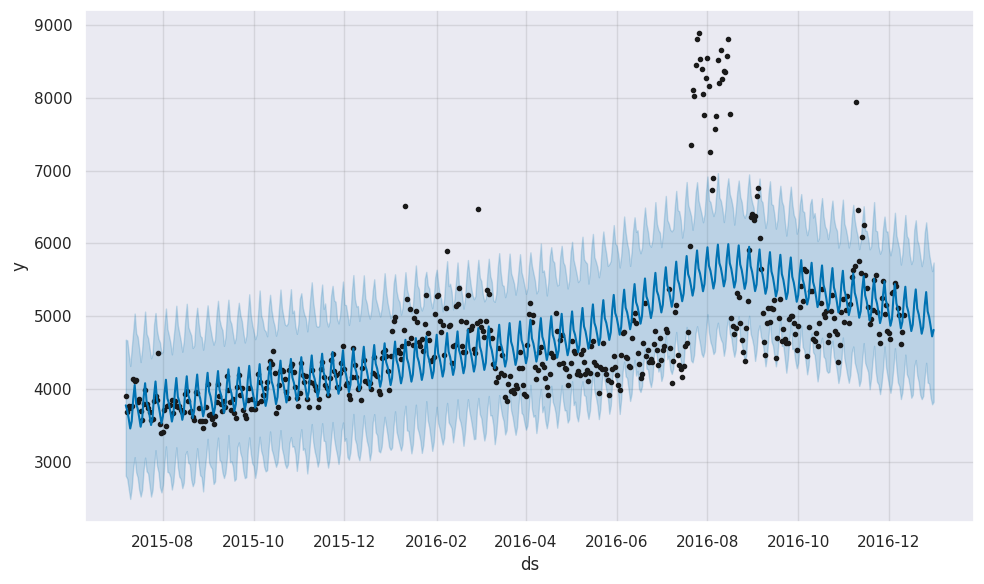

In [ ]:
from prophet import Prophet
m = Prophet(weekly_seasonality=True)
m.fit(df2[['ds', 'y']][:-20])
future = m.make_future_dataframe(periods=20,freq="D")
forecast = m.predict(future)
fig = m.plot(forecast)

### Prophet with exogenous

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpywf304zk/kiaf9mdy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpywf304zk/ox394oxl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24694', 'data', 'file=/tmp/tmpywf304zk/kiaf9mdy.json', 'init=/tmp/tmpywf304zk/ox394oxl.json', 'output', 'file=/tmp/tmpywf304zk/prophet_modelfspnxu18/prophet_model-20240404175051.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:50:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:50:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


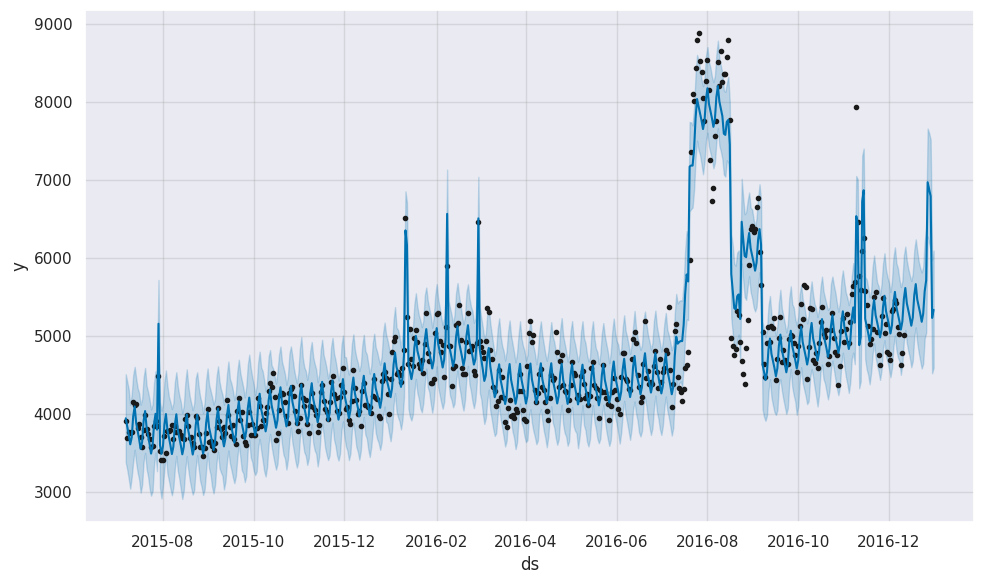

In [ ]:
model2=Prophet(interval_width=0.9, weekly_seasonality=True, changepoint_prior_scale=1)
model2.add_regressor('exog')
model2.fit(df2[:-20])
forecast2 = model2.predict(df2)
fig = model2.plot(forecast2)

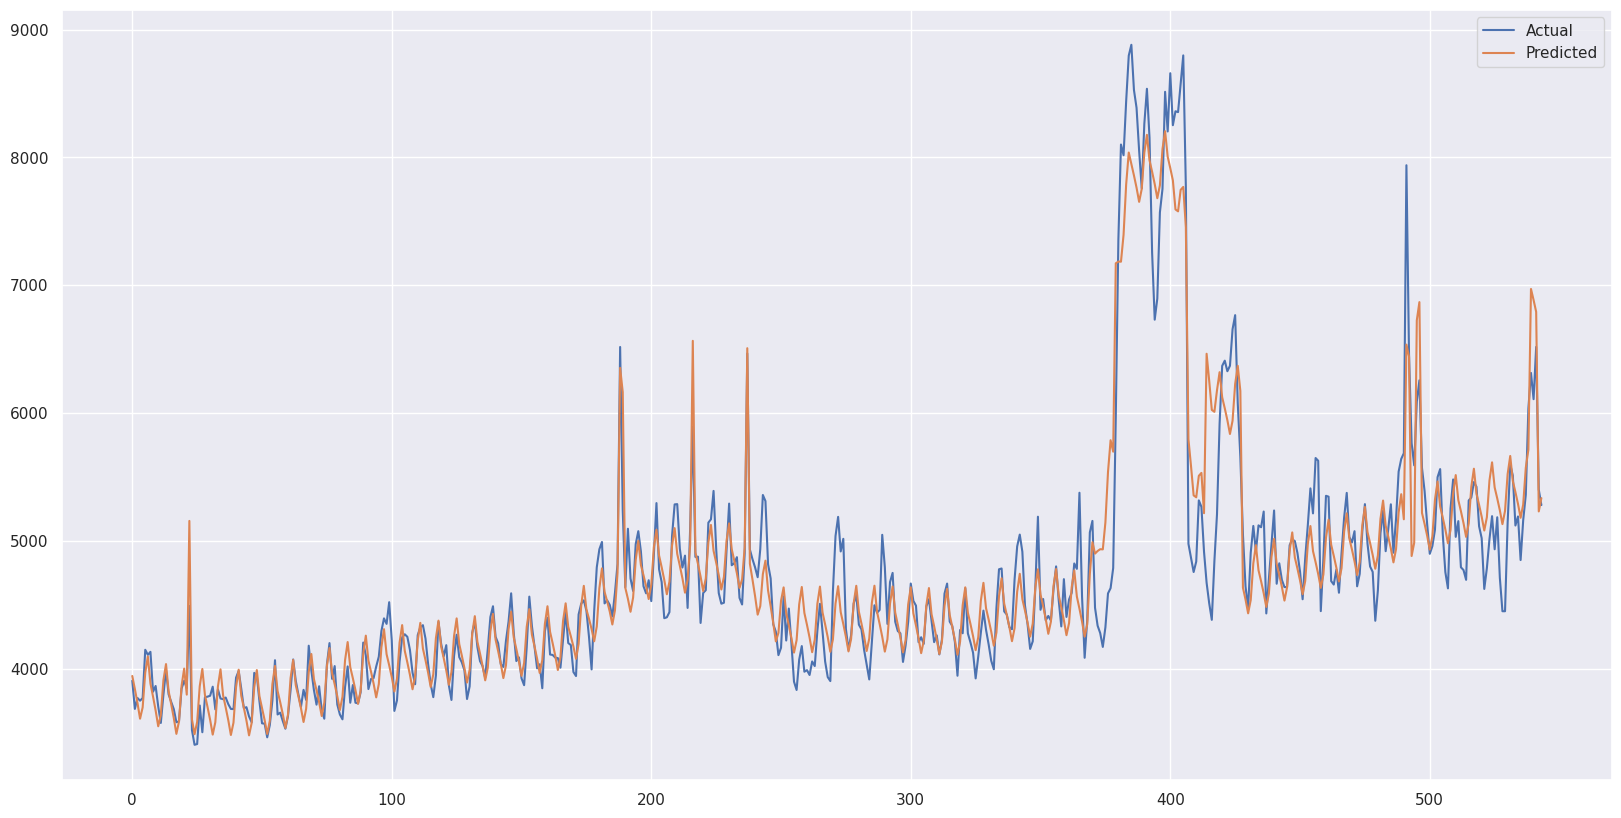

In [ ]:
y_true = df2['y'].values
y_pred = forecast2['yhat'].values

plot.plot(y_true, label='Actual')
plot.plot(y_pred, label='Predicted')
plot.legend()
plot.show()

In [ ]:
mape = np.mean(np.abs(forecast2['yhat'][-20:] - df2['y'][-20:].values)/np.abs(df2['y'][-20:].values))
print("mape:",mape)

mape: 0.06563482867071906


## Comparing the predicted views for different languages

Out of sample forecasting for the next month for each language.

In [ ]:
def grid_search(ts):
    v=[0,1,2,3]
    mape=100
    val=[0,0,0]
    for p in v:
        for d in v:
            for q in v:
                try:
                    model = ARIMA(ts[:-20], order=(p,d,q))
                    model_fit = model.fit(disp=-1)
                    fc, se, conf = model_fit.forecast(20, alpha=0.02)
                    x = np.mean(np.abs(fc - ts[-20:].values)/np.abs(ts[-20:].values))
                    if(x<mape):
                        mape=x
                        val=[p,d,q]

                except:
                    pass

    return(mape, val)

This functions works like a grid search for getting the best value of p,d,q by comparing the mape of all models that we create. The values of p,d,q that give the least mape score are saved and returned.

In [ ]:
def all_arima(train,test,val):
    model = ARIMA(train, order=(val[0], val[1], val[2]))
    fitted = model.fit()

  # Forecast
    fc = fitted.forecast(30, alpha=0.02)
    fc_series = pd.Series(fc, index=test.index)

  # Plot
    plot.figure(figsize=(12,5), dpi=100)
    plot.plot(train, label='training')
    plot.plot(test, label='actual')
    plot.plot(fc_series, label='forecast')
    plot.title('Forecast vs Actuals')
    plot.legend(loc='upper left', fontsize=8)
    plot.show()
    mape = np.mean(np.abs(fc - test.values)/np.abs(test.values))
    rmse = np.mean((fc - test.values)**2)**.5
    print("mape:",mape)
    print("rsme:",rmse)
    return (fc)


This function takes the p,d,q values that we calculated earlier and then trains a model on it, does forecast and plots them for visualization. It also calculates the sum of forecasted views for the next 30 days and returns it back.

language:  de
100 [0, 0, 0]


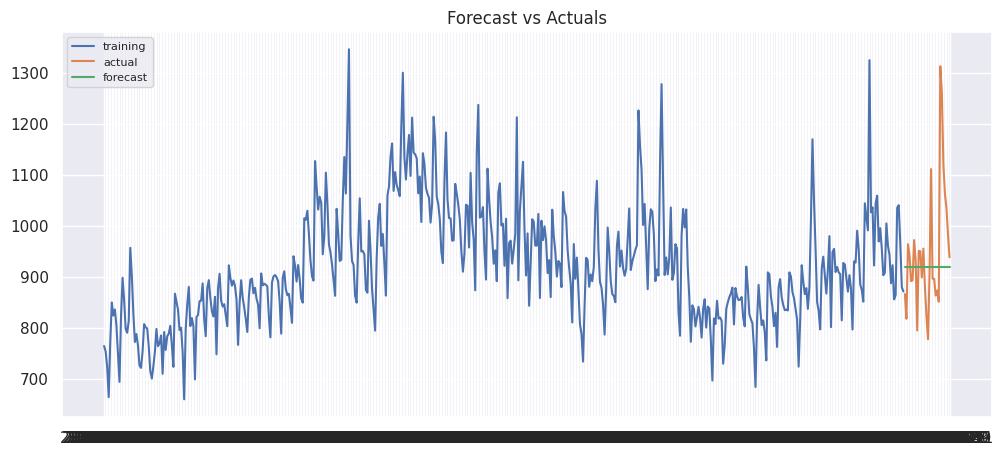

mape: 0.08433714607952147
rsme: 125.02398798986206
language:  en
100 [0, 0, 0]


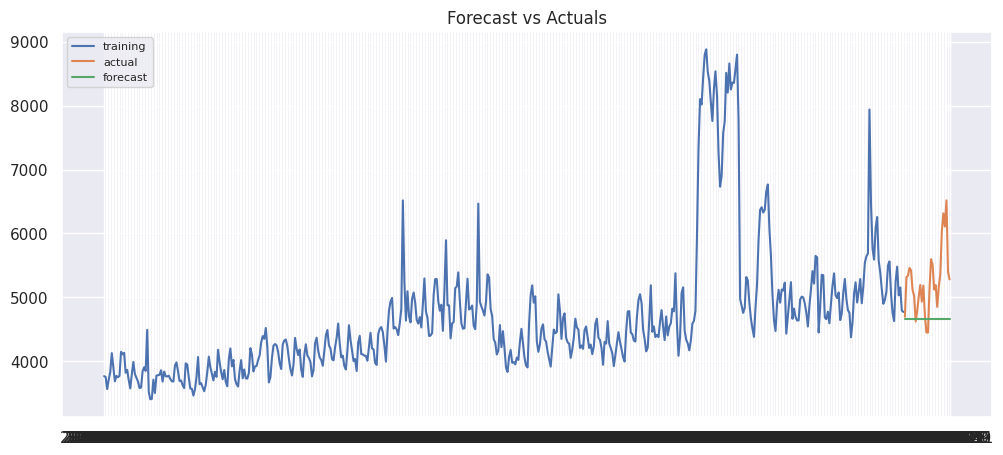

mape: 0.10994799500482501
rsme: 761.4523876477016
language:  es
100 [0, 0, 0]


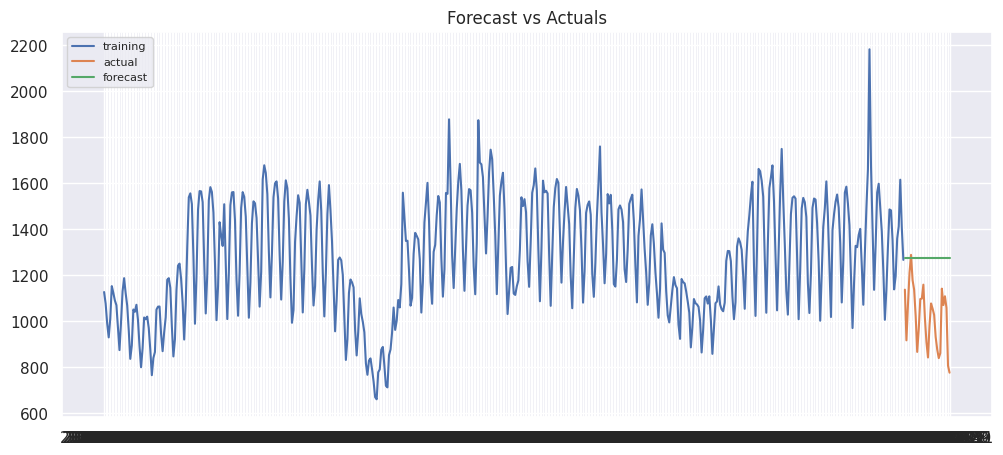

mape: 0.2757793993411583
rsme: 289.0479417345804
language:  fr
100 [0, 0, 0]


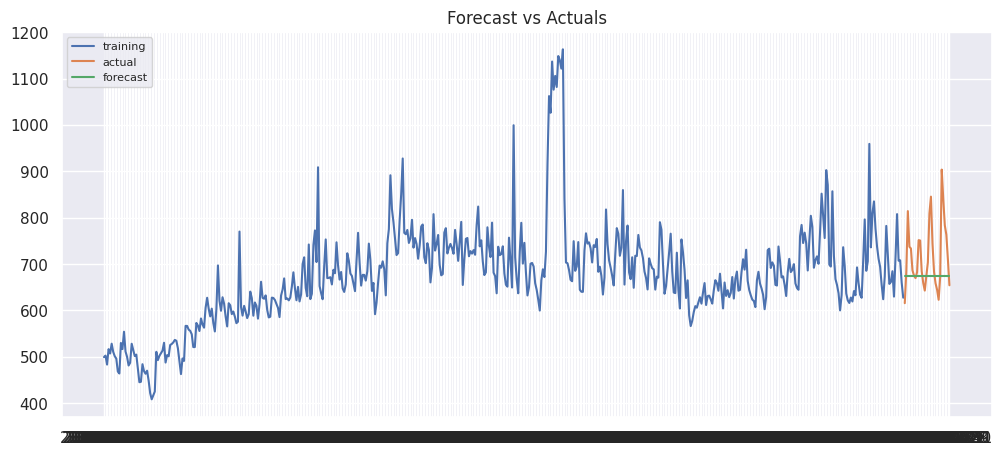

mape: 0.07484895957241428
rsme: 82.41479843053105
language:  ja
100 [0, 0, 0]


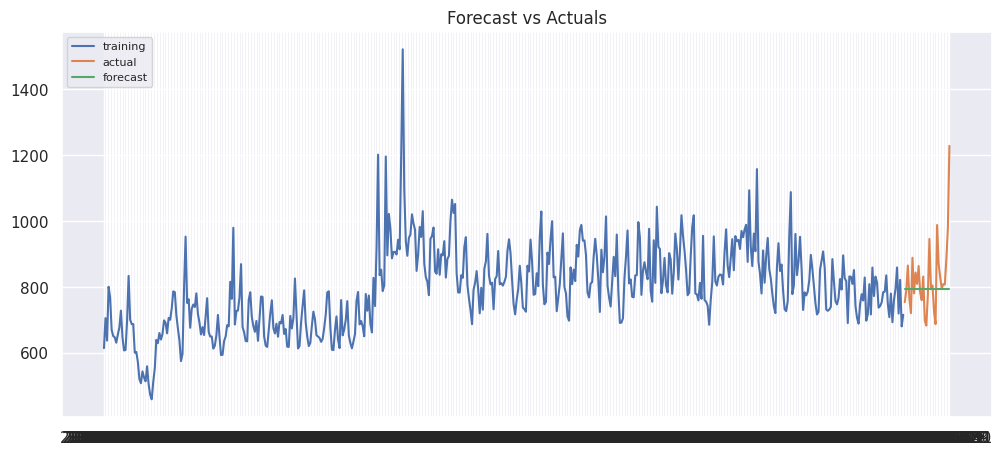

mape: 0.08086798924443844
rsme: 111.15945065900381
language:  no_lang
100 [0, 0, 0]


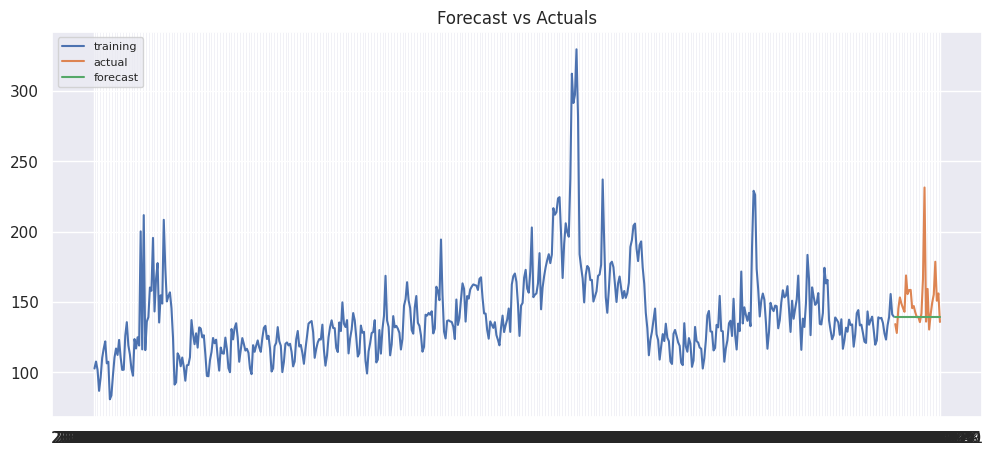

mape: 0.08211284038410901
rsme: 21.97335207316331
language:  ru
100 [0, 0, 0]


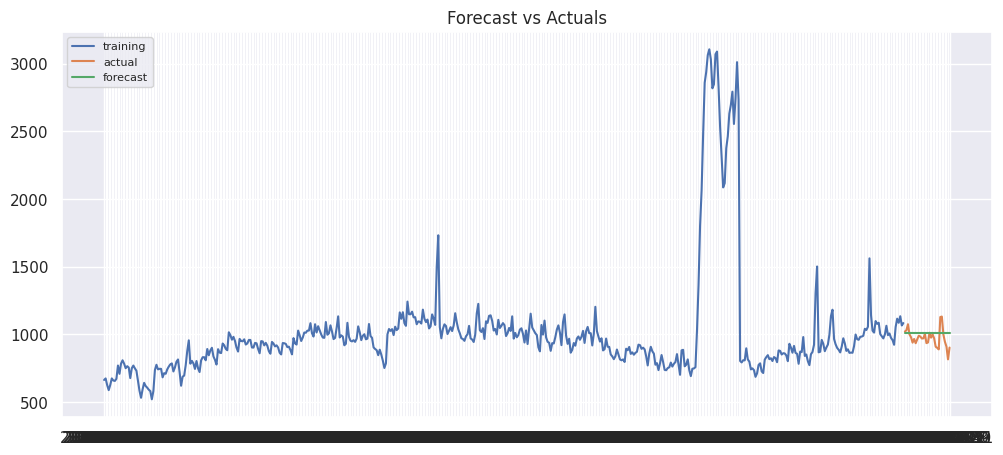

mape: 0.0635203540412519
rsme: 75.15323774301888
language:  zh
100 [0, 0, 0]


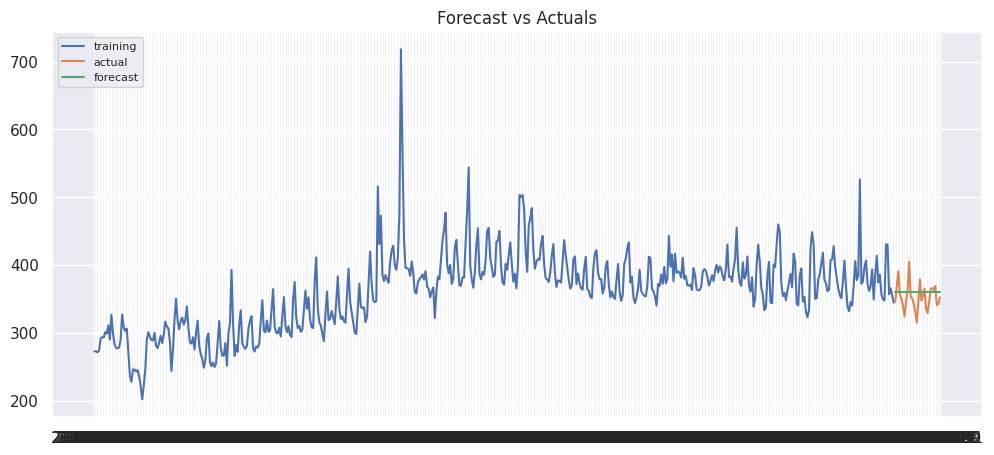

mape: 0.04704826295161647
rsme: 20.175020099403476


In [ ]:
import warnings
warnings.filterwarnings("ignore")
views_prediction={}
for c in total_view:
    print("language: ",c)
    ts=(total_view[c])
    mape,val=grid_search(ts)
    print(mape,val)
    train = ts[:520]
    test = ts[520:]
    fc=all_arima(train,test,val)
    views_prediction[c]=fc


-> Majority of articles are in language English.

-> Views from desktop and mobile are almost same.

-> Views from spider/bots are very less.

-> Shift by 1 gave stationary series.

-> English has most number of views. Japanese and German come in second and third place.
